# Regime classification
This Notebook reads discharge observations available across Canada, collected by Shervan Gharari (USask) beforehand from Water Survey of Canada (WSC) Hydrological Database ([HYDAT](https://wateroffice.ec.gc.ca/index_e.html)). From these data, it classifies the basins' regimes using circular statistics (from [Burn et al., 2010](https://doi.org/10.1002/hyp.7625)) to identify nival basins (basins with a snow-dominated regime).

Decisions:
- The nival regime definition (i.e., start and end doy & minimum regularity) was pre-defined by Paul Whitfield (USask) from expert knowledge of Canadian hydrology. See user-specified variables below.
- The water year definition: October 1st to September 30th. See user-specified variables below.
- For the peak over threshold calculations, the threshold used is the minimum value of all annual maxima.
- For the identification of nival basins with SWE stations, we require at least 30 years of overlap between the SWE & streamflow data. This threshold is set in order to keep basins where there is enough data to calibrate and forecast a forecasting model. See user-specified variables below.
- We could also select only basins with more recent data (e.g., >1960) to limit non-stationarity. Not implemented at this stage.
- Glacial basins are solely identified based on their peak DOY (from the 3 methods implemented).

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [1]:
# Import required modules
import math
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import circmean
from shapely.geometry import Point
import datetime
from datetime import date

In [2]:
# Set required data paths
streamflow_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/streamflow_obs/Canada_old/"  # streamflow observations directory
shp_path = "/Users/lla068/Documents/data_driven_forecasting/basins/Canada_old/"  # basin shapefiles directory
SWE_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/snow_obs/Canada/CanSWE/ECCC_CanSWE-CanEEN_1928-2021_v3_DONOTSHARE.nc"  # CanSWE (1928,2020) SWE stations observations NetCDF compiled by ECCC (see: https://zenodo.org/record/4734372#.YUUXKi1b1mB). With additional private data from QC
RHBN_stations_path = "/Users/lla068/Documents/data_driven_forecasting/basins/Canada/RHBN_Metadata.xlsx"  # RHBN stations with limited human influence across Canada. See: https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/reference-hydrometric-basin-network.html
plots_output_path = "/Users/lla068/Documents/data_driven_forecasting/paper/figures/" # directory to store output plots

In [4]:
# Set user-specified variables
nival_start_doy_default = 60  # nival regime starting day of year
nival_end_doy_default = 213  # nival regime ending day of year
nival_regularity_threshold_default = 0.65  # nival regime minimum regularity threshold
raindriven_start_doy_default = 274  # rainfall-driven regime starting day of year
raindriven_end_doy_default = 30  # rainfall-driven regime ending day of year
raindriven_regularity_threshold_default = 0.45  # rainfall-driven regime minimum regularity threshold
testbasin_id = '07OB001'  # test basin ID taken from WSC HYDAT
testbasin_name = ''  # test basin name taken from WSC HYDAT
HYDAT_regions = ['01','02','03','04','05','06','07','08','09','10','11'] # list of WSC HYDAT regions
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_years_overlap_default = 30  # the minimum number of years of overlap between SWE and Q data we require
glacial_min_doy_default = 182  # 1st of July: the DOY passed which we assume that basins have a glacial regime. This is a conservative value to make sure we capture all basins with a glacial regime

In [5]:
def extract_stations_in_basin(stations, basins, basin_id, buffer_km=0):
    
    """Extracts stations within a specified basin (with or without a buffer) and returns the extracted stations.
    
    Keyword arguments:
    ------------------
    - stations: Pandas GeoDataFrame of all stations available to subset from
    - basins: Pandas GeoDataFrame of all basin shapefiles available to subset from
    - basin_id: String of basin station ID
    - buffer_km: Positive value (in km) of buffer to add around basin shapefile (default=0; i.e., no buffer)
    
    Returns:
    --------
    - stations_in_basin: Pandas GeoDataFrame of all stations within the specified basin
    - basin_buffer: Zero if the default buffer is selected, otherwise buffer geometry for plotting
    
    """
    
    # Extract SWE stations within basin only (i.e., no buffer)
    if buffer_km == 0:
        basin_buffer = 0        
        mask = stations.within(basins.loc[basins['Station'] == basin_id].iloc[0].loc["geometry"])

    # Extract SWE stations within specified buffer of basin
    elif buffer_km > 0:
        
        # convert basin & stations geometry to a different CRS to be able to add a buffer in meters
        basin_crs_conversion = basins.loc[basins['Station'] == basin_id].to_crs(epsg=3763)
        stations_crs_conversion = stations.to_crs(epsg=3763)
        
        # add a buffer in meters around the basin
        buffer_m = buffer_km * 1000
        basin_buffer = basin_crs_conversion.buffer(buffer_m)
        mask = stations_crs_conversion.within(basin_buffer.iloc[0])
        
        # convert the buffer back to the original CRS for plotting
        basin_buffer = basin_buffer.to_crs(epsg=4326)

    stations_in_basin = stations.loc[mask].assign(basin=basin_id)
    
    return stations_in_basin, basin_buffer

In [6]:
def circular_stats(doy, year_length):
    
    """Calculates circular statistics. See: https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.7625
    
    Keyword arguments:
    ------------------
    - doy: Numpy array of day of year (doy) values for identified streamflow peaks
    - year_length: Numpy array of year length values for identified streamflow peaks
    
    Returns:
    --------
    - theta_rad: Numpy array of the angular values (in radians) that correspond to the doy
    - regularity: Dimensionless value indicating the spread of the data (ranges from 0: high spread to 1: low spread)
    
    """
    
    theta_rad = doy * ((2*math.pi)/year_length)
    x_coord = np.mean([math.cos(x) for x in theta_rad])
    y_coord = np.mean([math.sin(x) for x in theta_rad])
    regularity = math.sqrt(x_coord**2 + y_coord**2)
    
    return theta_rad, regularity

In [7]:
def polar_plot(theta_rad, regularity, flag, nival_start_doy, nival_end_doy, nival_regularity_threshold, raindriven_start_doy, raindriven_end_doy, raindriven_regularity_threshold):
    
    """Plots circular statistics on a polar plot for a single or multiple basins.
    
    Keyword arguments:
    ------------------
    - theta_rad: Numpy array of the angular values (in radians) that correspond to the doy
    - regularity: Dimensionless value indicating the spread of the data (ranges from 0: high spread to 1: low spread)
    - flag: Flag to indicate if a single (0) or multiple (1) basins should be plotted
    - nival_start_doy: Integer day of year (doy) of the start of the nival period
    - nival_end_doy: Integer day of year (doy) of the end of the nival period
    - nival_regularity_threshold: Float between 0 and 1 of the minimum regularity threshold allowed for basins to be categorized as being nival
    - raindriven_start_doy: Integer day of year (doy) of the start of the rainfall-driven period
    - raindriven_end_doy: Integer day of year (doy) of the end of the rainfall-driven period
    - raindriven_regularity_threshold: Float between 0 and 1 of the minimum regularity threshold allowed for basins to be categorized as being rainfall-driven
    
    Returns:
    --------
    - A polar plot of circular statistics.
    
    """
    
#     # Set up figure
#     fig = plt.figure()

    # Initialize the figure
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(polar=True)
    lines, labels = plt.thetagrids(np.arange(0,361,30),['1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'])
    ax.set_theta_zero_location('S')
    ax.set_theta_direction(-1)
    ax.tick_params(pad=10)
    
    # Plot circular statistics for a single basin - i.e., individual events are shown
    if flag == 0:
        plt.plot(circmean(theta_rad), regularity, 'ko', label='circular statistics')
        plt.plot(theta_rad, [1.1]*len(theta_rad), 'bs', ms=5, label='events');
    
    # Plot circular statistics for multiple basins - i.e., individual events are not shown
    elif flag == 1:
        plt.plot(theta_rad, regularity, 'ko')
        
    # Add information on polar plot about rainfall-driven & nival regimes
    nival_start = nival_start_doy * ((2*math.pi)/365)
    nival_end = nival_end_doy * ((2*math.pi)/365)
    plt.fill_between(np.linspace(nival_start, nival_end, 100), nival_regularity_threshold, 1, color='b', alpha=.2, label='nival')
    raindriven_start_1 = raindriven_start_doy * ((2*math.pi)/365)
    raindriven_end_1 = 365 * ((2*math.pi)/365)
    raindriven_start_2 = 0 * ((2*math.pi)/365)
    raindriven_end_2 = raindriven_end_doy * ((2*math.pi)/365)
    plt.fill_between(np.linspace(raindriven_start_1, raindriven_end_1, 100), raindriven_regularity_threshold, 1, color='g', alpha=.2, label='rainfall-driven')
    plt.fill_between(np.linspace(raindriven_start_2, raindriven_end_2, 100), raindriven_regularity_threshold, 1, color='g', alpha=.2)

    plt.legend(loc=(1,1));

In [8]:
def basins_maps(basins, method, title_end, colours_column, nival_start_doy, nival_end_doy):
    
    """Plots two maps of basins provided, one that shows the basins' shapes & one that shows the basins' outlets.
    
    Keyword arguments:
    ------------------
    - basins: Pandas GeoDataFrame of all basin shapefiles available to subset from
    - method: String of the metric used to identify streamflow peaks (shown on maps' title)
    - title_end: String of a note to add at the end of the maps' title (e.g., referring to the basins shown)
    - colours_column: String of the column label to be used for colouring the maps
    - nival_start_doy: Integer day of year (doy) of the start of the nival period
    - nival_end_doy: Integer day of year (doy) of the end of the nival period
    
    Returns:
    --------
    - Two maps of basins.
    
    """
    
    # Plot map of basins' shapes
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_na = world[world['continent']=='North America'].copy()
    world_na_albers = world_na.to_crs("ESRI:102008")
    ax = world_na_albers.plot(figsize=(20,5), linewidth=1, edgecolor='grey', color='white')
    basins_albers = basins.to_crs("ESRI:102008")
    # sorting the basins by area so that smaller basins aren't hidden under larger basins that encompass them
    basins_albers.sort_values(by=['Shp_Area'], ascending=False).plot(ax=ax, column=colours_column, cmap=plt.cm.viridis, vmin=nival_start_doy, vmax=nival_end_doy, legend=True, legend_kwds={'label':'DOY'})  
    minx, miny, maxx, maxy = np.nanmin(world_na_albers.geometry.bounds.minx),np.nanmin(world_na_albers.geometry.bounds.miny),np.nanmax(world_na_albers.geometry.bounds.maxx),np.nanmax(world_na_albers.geometry.bounds.maxy)
    ax.set_xlim(minx+1500000, maxx-500000)
    ax.set_ylim(miny+1000000, maxy-500000)
    ax.margins(0)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.title('Nival/glacial basins ('+method+')'+title_end)
    plt.text(minx+1700000,miny+1200000,'Total basins='+str(len(basins.index)))
    ax.set_facecolor('azure');

    # Plot map of basins' outlets
    ax = world_na_albers.plot(figsize=(20,5), linewidth=1, edgecolor='grey', color='white')
    basins_pt = basins.copy()
    basins_pt = gpd.GeoDataFrame(basins_pt, geometry=gpd.points_from_xy(basins_pt.outlet_lon, basins_pt.outlet_lat))
    basins_pt.crs = {"init":"epsg:4326"}
    basins_pt_albers = basins_pt.to_crs("ESRI:102008")
    basins_pt_albers.plot(ax=ax, column=colours_column, cmap=plt.cm.viridis, legend=True, legend_kwds={'label':'DOY'}, alpha=.5, markersize=5)            
    ax.set_xlim(minx+1500000, maxx-500000)
    ax.set_ylim(miny+1000000, maxy-500000)
    ax.margins(0)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.title('Nival/glacial basins ('+method+')'+title_end)
    plt.text(minx+1700000,miny+1200000,'Total basins='+str(len(basins.index)))
    ax.set_facecolor('azure');

In [9]:
def streamflow_peaks_statistics(streamflow_data, flag):
    
    """Identifies the streamflow peaks for a given method (i.e., flag).
    
    Keyword arguments:
    ------------------
    - streamflow_data: Pandas DataFrame of the daily streamflow observations for a basin
    - flag: An integer of 1, 2 or 3 defining the method to be used for identifying streamflow peaks
      -> flag=1: streamflow annual maxima
      -> flag=2: peak over threshold (POT) where the threshold = minimum value of all annual maxima
      -> flag=3: annual centres of mass (i.e., doy where 1/2 of the total water year streamflow has passed through the river - see: https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml)

    Returns:
    --------
    - streamflow_stats: Pandas DataFrame of the streamflow peaks statistics
    
    """
    
    # Calculate streamflow annual maxima - we need the annual maxima to calculate the POT
    if flag == 1 or flag == 2:
        streamflow_data_peaks = streamflow_data.groupby("water_year").Flow.max().dropna(axis=0)
        streamflow_data_peaks_doys = streamflow_data.groupby("water_year").Flow.idxmax(skipna=False).dropna(axis=0)
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks_doys.values, index=streamflow_data_peaks_doys.index, columns=["doy"])
        dates = pd.to_datetime([str(x)+"-01-01" for x in streamflow_stats.index.values], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        streamflow_stats['annual_maxima'] = streamflow_data_peaks[streamflow_data_peaks_doys.index]
        
    # Calculate peak over threshold (POT)
    if flag == 2:
        threshold = streamflow_stats['annual_maxima'].min() # threshold = minimum value of all annual maxima
        streamflow_data_peaks = streamflow_data[streamflow_data.Flow>threshold]
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks).drop(columns=['Station_ID','time','lat','lon']).reset_index()
        dates = pd.to_datetime([str(x)+"-01-01" for x in streamflow_stats.year.values], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        
    # Centre of mass - https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml
    elif flag == 3:
        streamflow_data_peaks = []
        streamflow_data_peaks_doys = []
        water_years = []
        for wy in list(set(streamflow_data['water_year'].values)):
            streamflow_cumsum = streamflow_data[streamflow_data['water_year']==wy].Flow.cumsum(skipna=True)
            if streamflow_cumsum.isnull().values.any() == False:
                water_years.append(wy)
                mid_pt = streamflow_cumsum.values[-1]/2
                mid_pt_position = np.abs(streamflow_cumsum.values - mid_pt).argmin()
                centre_of_mass = streamflow_cumsum.iloc[mid_pt_position]
                streamflow_data_peaks.append(centre_of_mass)
                streamflow_data_peaks_doys.append(streamflow_cumsum[streamflow_cumsum==centre_of_mass].index.values[0])
            else:
                continue
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks_doys, index=np.arange(len(streamflow_data_peaks_doys)), columns=["doy"])
        dates = pd.to_datetime([str(x)+"-01-01" for x in water_years], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        streamflow_stats['centre_of_mass'] = streamflow_data_peaks
        
    return streamflow_stats

In [10]:
def regime_classification(streamflow_obs_path, shp_path, start_water_year, flag):
    
    """Performs the regime classification for a given method (i.e., flag).
    
    Keyword arguments:
    ------------------
    - streamflow_obs_path: String of streamflow observations directory
    - shp_path: String of basin shapefiles directory
    - start_water_year: Tuple with (month, day) of the water year starting date
    - flag: An integer of 1, 2 or 3 defining the method to be used for identifying streamflow peaks
      -> flag=1: streamflow annual maxima
      -> flag=2: peak over threshold (POT) where the threshold = minimum value of all annual maxima
      -> flag=3: annual centres of mass (i.e., doy where 1/2 of the total water year streamflow has passed through the river - see: https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml)

    Returns:
    --------
    - basins_regimes: Pandas GeoDataFrame containing station information (e.g., outlet lat, lon and ID) & circular statistics for all stations available from WSC HYDAT
    
    """

    # Set empty lists to store information on stations & their circular statistics
    id_stations = []
    theta_rad_stations = []
    regularity_stations = []
    doy_stations = []
    lat_stations = []
    lon_stations = []

    # Set counter to merge all shapefiles into one Pandas GeoDataFrame
    count = 0

    # Loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
    for r in ['01','02','03','04','05','06','07','08','09','10','11']:
        
        # open streamflow observations data
        streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
        
        # open basin shapefiles
        basins_shp = gpd.read_file(shp_path+r+".shp")
        
        count += 1
        
        # append shapefiles
        if count == 1:
            merged_basins_shp = basins_shp
        else:
            merged_basins_shp = merged_basins_shp.append(basins_shp)

        # loop over stations with streamflow data within the region
        for s in streamflow_data_ds.Station_ID.values:

            # check that the station has a corresponding basin shapefile  
            if s in basins_shp.Station.values:
                            
                # read streamflow observations as Pandas DataFrame
                streamflow_data_da = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow
                streamflow_data_da = streamflow_data_da.set_index({"Station_ID":"Station_ID"})
                streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})
                streamflow_data_df = streamflow_data_da.to_dataframe()
                streamflow_data_df.reset_index(inplace=True)
                streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)
                streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
                streamflow_data_df = streamflow_data_df.set_index('doy')
                
                # add a water year column
                water_year = []
                for i in pd.DatetimeIndex(streamflow_data_df.time.values):
                    if (i.month == start_water_year[0] and i.day >= start_water_year[1]) or (i.month > start_water_year[0]):
                        water_year.append(i.year + 1)
                    else:
                        water_year.append(i.year)
                streamflow_data_df['water_year'] = water_year
                
                # calculate the basin's streamflow statistics for the chosen method
                streamflow_stats = streamflow_peaks_statistics(streamflow_data_df, flag)
                
                # calculate the basin's circular statistics
                if streamflow_stats.empty == False:                    
                    theta_rad, regularity = circular_stats(streamflow_stats.doy.values, streamflow_stats.length_year.values)
                    
                    # save the circular statistics & basin's information
                    lat_stations.append(streamflow_data_df.lat.values[0])
                    lon_stations.append(streamflow_data_df.lon.values[0])
                    id_stations.append(s)
                    theta_rad_stations.append(circmean(theta_rad))
                    regularity_stations.append(regularity)
                    doy_stations.append(circmean(streamflow_stats.doy.values, high=366, low=1))
        
    # Create Pandas DataFrame to store all basins' circular statistics
    regimes_data = pd.DataFrame(data=np.column_stack((lat_stations, lon_stations, theta_rad_stations, regularity_stations, doy_stations)), index=id_stations, columns=["outlet_lat","outlet_lon","theta_rad","regularity","doy"])

    # Combine the basins' shapefiles Pandas GeoDataFrame with the regime classification information
    basins_regimes = merged_basins_shp.set_index('Station').merge(regimes_data, left_index=True, right_index=True, how='outer')
    
    return basins_regimes

In [11]:
def cumulative_hydrographs(basins, streamflow_obs_path, month_start_water_year, day_start_water_year):
    
    """Plots normalized cumulative climatological streamflows for the provided basins, differenciating between nival and glacial basins.
    
    Keyword arguments:
    ------------------
    - basins: Pandas GeoDataFrame of all basins to plot
    - streamflow_obs_path: String of streamflow observations directory
    - month_start_water_year: Integer of the water year starting month
    - day_start_water_year: Integer of the water year starting day of the month

    Returns:
    --------
    - A plot of all basins' cumulative climatological hydrographs.
    
    """
    # Set up figure
    fig = plt.figure()
    
    # We expect to see RuntimeWarnings in this block due to missing values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        cumsum_norm_nivalbasins = np.ones((len(basins[basins.regime=='nival'].index),366))
        cumsum_norm_glacialbasins = np.ones((len(basins[basins.regime=='glacial'].index),366))
        
        nniv = -1
        nglac = -1
        
        # calculate the number of days between the water year and calendar start
        start_water_year = date(2020,month_start_water_year,day_start_water_year)
        start_calendar_year = date(2021,1,1)
        delta = (start_calendar_year - start_water_year).days

        # loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
        for r in ['01','02','03','04','05','06','07','08','09','10','11']:

            # open streamflow observations data
            streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
            streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
            streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})

            # extract all stations for plotting that fall within the region
            stations_idx_inregion = [x for x in basins.index.values if x.startswith(r)]

            # loop over the region's stations
            for s in stations_idx_inregion:

                # calculate the climatological mean flow for each DOY
                doy_mean = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow.groupby("time.dayofyear").mean(skipna=True)
                
                # calculate water year doy to accumulate flow for the water year vs. calendar year
                wateryear_doy = [(x+delta)%367 for x in np.arange(1,366+1)]
                for i in range(len(wateryear_doy)):
                    if wateryear_doy[i] < delta:
                        wateryear_doy[i] += 1
                doy_mean = doy_mean.assign_coords(wateryear_doy=('dayofyear', wateryear_doy))
                doy_mean = doy_mean.sortby('wateryear_doy')
                
                # calculate the normalized cumulative sum over this climatological timeseries - we normalize so that all basins hydrographs can be plotted on a single plot 
                cumsum_norm = doy_mean.cumsum() / doy_mean.cumsum().values[0][-1]
                
                # save the values to numpy array
                if basins.loc[s].regime == 'nival':
                    nniv += 1
                    cumsum_norm_nivalbasins[nniv,:] = cumsum_norm
                    
                elif basins.loc[s].regime == 'glacial':
                    nglac += 1
                    cumsum_norm_glacialbasins[nglac,:] = cumsum_norm
        
        # calculate values quantiles
        niv_med = np.quantile(cumsum_norm_nivalbasins, [0,.25,.5,.75,1], axis=0)

        # plotting
        plt.plot(np.arange(366), niv_med[2,:], color='b', label='nival basins')
        plt.fill_between(np.arange(366), niv_med[1,:], niv_med[3,:], color='b', alpha=.3, lw=0)
        plt.fill_between(np.arange(366), niv_med[0,:], niv_med[4,:], color='b', alpha=.3, lw=0)
        
        # check that there is data for glacial basins
        if nglac > -1:

            # calculate values quantiles
            glac_med = np.quantile(cumsum_norm_glacialbasins, [0,.25,.5,.75,1], axis=0)

            # plotting
            plt.plot(np.arange(366), glac_med[2,:], color='darkturquoise', label='glacial basins')
            plt.fill_between(np.arange(366), glac_med[1,:], glac_med[3,:], color='darkturquoise', alpha=.3, lw=0)
            plt.fill_between(np.arange(366), glac_med[0,:], glac_med[4,:], color='darkturquoise', alpha=.3, lw=0)
        
        plt.legend()
        plt.title('')
        plt.ylabel('cdf of Q climatological mean [norm.]')
        plt.xticks(np.arange(0,360,30),['1st Oct', '1st Nov', '1st Dec', '1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep'], rotation=45)
        plt.xlabel('water year DOY')
        
    return fig;  

In [12]:
def hydrographs(basins, streamflow_obs_path, month_start_water_year, day_start_water_year):
    
    """Plots normalized climatological streamflows for the provided basins, differenciating between nival and glacial basins.
    
    Keyword arguments:
    ------------------
    - basins: Pandas GeoDataFrame of all basins to plot
    - streamflow_obs_path: String of streamflow observations directory
    - month_start_water_year: Integer of the water year starting month
    - day_start_water_year: Integer of the water year starting day of the month

    Returns:
    --------
    - A plot of all basins' climatological hydrographs.
    
    """
    # Set up figure
    fig = plt.figure()
    
    # We expect to see RuntimeWarnings in this block due to missing values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        norm_nivalbasins = np.ones((len(basins[basins.regime=='nival'].index),366))
        norm_glacialbasins = np.ones((len(basins[basins.regime=='glacial'].index),366))
        
        nniv = -1
        nglac = -1
        
        # calculate the number of days between the water year and calendar start
        start_water_year = date(2020,month_start_water_year,day_start_water_year)
        start_calendar_year = date(2021,1,1)
        delta = (start_calendar_year - start_water_year).days

        # loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
        for r in ['01','02','03','04','05','06','07','08','09','10','11']:

            # open streamflow observations data
            streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
            streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
            streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})

            # extract all stations for plotting that fall within the region
            stations_idx_inregion = [x for x in basins.index.values if x.startswith(r)]

            # loop over the region's stations
            for s in stations_idx_inregion:

                # calculate the climatological mean flow for each DOY
                doy_mean = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow.groupby("time.dayofyear").mean(skipna=True)
                
                # calculate water year doy to accumulate flow for the water year vs. calendar year
                wateryear_doy = [(x+delta)%367 for x in np.arange(1,366+1)]
                for i in range(len(wateryear_doy)):
                    if wateryear_doy[i] < delta:
                        wateryear_doy[i] += 1
                doy_mean = doy_mean.assign_coords(wateryear_doy=('dayofyear', wateryear_doy))
                doy_mean = doy_mean.sortby('wateryear_doy')
                
                # calculate the normalized cumulative sum over this climatological timeseries - we normalize so that all basins hydrographs can be plotted on a single plot 
                norm = doy_mean / doy_mean.cumsum().values[0][-1]
                
                # save the values to numpy array
                if basins.loc[s].regime == 'nival':
                    nniv += 1
                    norm_nivalbasins[nniv,:] = norm
                    
                elif basins.loc[s].regime == 'glacial':
                    nglac += 1
                    norm_glacialbasins[nglac,:] = norm
        
        # calculate values quantiles
        # Note: we start at .1 and end at .9 to remove noise with extremes
        niv_med = np.quantile(norm_nivalbasins, [.1,.25,.5,.75,.9], axis=0)

        # plotting
        plt.plot(np.arange(366), niv_med[2,:], color='b', label='nival basins')
        plt.fill_between(np.arange(366), niv_med[1,:], niv_med[3,:], color='b', alpha=.3, lw=0)
        plt.fill_between(np.arange(366), niv_med[0,:], niv_med[4,:], color='b', alpha=.3, lw=0)
        
        # check that there is data for glacial basins
        if nglac > -1:

            # calculate values quantiles
            # Note: we start at .1 and end at .9 to remove noise with extremes
            glac_med = np.quantile(norm_glacialbasins, [.1,.25,.5,.75,.9], axis=0)

            # plotting
            plt.plot(np.arange(366), glac_med[2,:], color='darkturquoise', label='glacial basins')
            plt.fill_between(np.arange(366), glac_med[1,:], glac_med[3,:], color='darkturquoise', alpha=.3, lw=0)
            plt.fill_between(np.arange(366), glac_med[0,:], glac_med[4,:], color='darkturquoise', alpha=.3, lw=0)
        
        plt.legend()
        plt.title('')
        plt.ylabel('Q climatological mean [norm.]')
        plt.xticks(np.arange(0,360,30),['1st Oct', '1st Nov', '1st Dec', '1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep'], rotation=45)
        plt.xlabel('water year DOY')
        
    return fig;  

# Regime classification
To identify basins with a nival/glacial regime vs. rainfall-driven regime. 

## For a test basin
Let's go over the regime classification for a test basin (specified at the top of the Notebook) to see how it works.

In [13]:
# Read the station daily streamflow data as a DataArray 
streamflow_file = xr.open_dataset(streamflow_obs_path+"HYDAT_"+testbasin_id[:2]+".nc")
streamflow_data_da = streamflow_file.where(streamflow_file.Station_ID==testbasin_id, drop=True).Flow #because Station_ID not indexed
streamflow_data_da = streamflow_data_da.set_index({"Station_ID":"Station_ID"})
streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})

display(streamflow_data_da)

<xarray.DataArray 'Flow' (Station_ID: 1, time: 62092)>
array([[nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time        (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2020-01-01
    lat         (Station_ID) float64 60.74
    lon         (Station_ID) float64 -115.9
  * Station_ID  (Station_ID) object '07OB001'
Attributes:
    long_name:  Daily flow
    units:      m**3 s**-1

In [14]:
# Re-organize data with day of year (doy) and water years information

# transform the DataArray into a Pandas DataFrame for data manipulations
streamflow_data_df = streamflow_data_da.to_dataframe()

# reset index to set doy as a new index
streamflow_data_df.reset_index(inplace=True)

# add a new column for the years
streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)

# loop over the data years to create a new column with water years
water_year = []
for i in pd.DatetimeIndex(streamflow_data_df.time.values):
    if (i.month == month_start_water_year_default and i.day >= day_start_water_year_default) or (i.month > month_start_water_year_default):
        water_year.append(i.year + 1)
    else:
        water_year.append(i.year)
streamflow_data_df['water_year'] = water_year

# create a new column with doy and set as DataFrame index
streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
streamflow_data_df = streamflow_data_df.set_index('doy')

display(streamflow_data_df)

,Station_ID,time,lat,lon,Flow,year,water_year
doy,,,,,,,
1,07OB001,1850-01-01,60.743,-115.859642,NaN,1850,1850
2,07OB001,1850-01-02,60.743,-115.859642,NaN,1850,1850
3,07OB001,1850-01-03,60.743,-115.859642,NaN,1850,1850
4,07OB001,1850-01-04,60.743,-115.859642,NaN,1850,1850
5,07OB001,1850-01-05,60.743,-115.859642,NaN,1850,1850
...,...,...,...,...,...,...,...
362,07OB001,2019-12-28,60.743,-115.859642,NaN,2019,2020
363,07OB001,2019-12-29,60.743,-115.859642,NaN,2019,2020
364,07OB001,2019-12-30,60.743,-115.859642,NaN,2019,2020


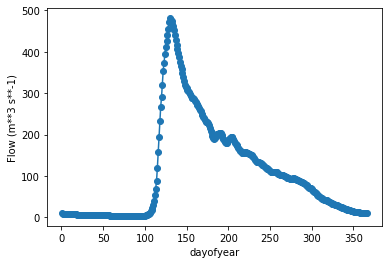

In [15]:
# Plot the test basin's mean climatology to understand its response and when the peak flow(s) happen
testbasin_streamflow_climatology_means = streamflow_data_da.groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
testbasin_streamflow_climatology_means.plot(marker='o')
plt.ylabel('Flow ('+streamflow_data_da.attrs['units']+')');

### Streamflow statistics
Below, we calculate 3 streamflow statistics that can be used for peak streamflow events identification: streamflow annual maxima, peaks over threshold (POT) & centre of mass. The reason behind calculating all 3 statistics is that none of these are fully reliable. Hence, we use a combination of all 3.

,doy,length_year,annual_maxima
water_year,,,
1964,129.0,366,725.0
1965,122.0,365,750.0
1966,130.0,365,620.0
1967,131.0,365,900.0
1968,127.0,366,518.0


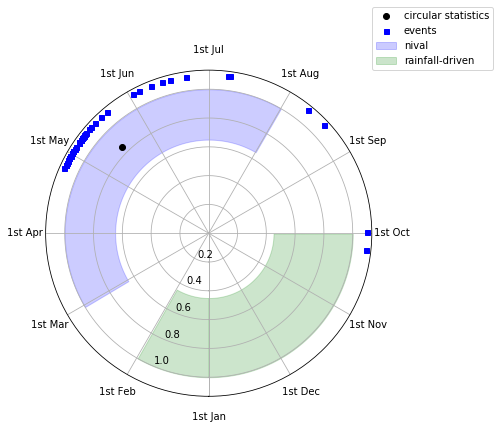

In [16]:
# Calculate streamflow annual maxima
streamflow_stats_annualmax = streamflow_peaks_statistics(streamflow_data_df, flag=1)

display(streamflow_stats_annualmax.head())

# Create polar plot
theta_rad_annualmax, regularity_annualmax = circular_stats(streamflow_stats_annualmax.doy.values, streamflow_stats_annualmax.length_year.values)
polar_plot(theta_rad_annualmax, regularity_annualmax, 0, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

,doy,Flow,year,water_year,length_year
0,179,216.0,1963,1963,365
1,180,213.0,1963,1963,365
2,181,210.0,1963,1963,365
3,182,207.0,1963,1963,365
4,183,202.0,1963,1963,365


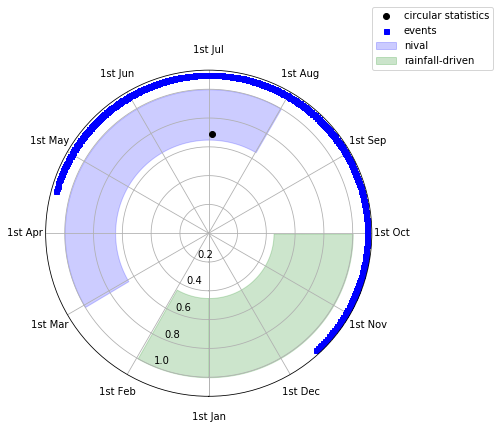

In [17]:
# Calculate streamflow POT
streamflow_stats_POT = streamflow_peaks_statistics(streamflow_data_df, flag=2)

display(streamflow_stats_POT.head())

# Create polar plot
theta_rad_POT, regularity_POT = circular_stats(streamflow_stats_POT.doy.values, streamflow_stats_POT.length_year.values)
polar_plot(theta_rad_POT, regularity_POT, 0, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

,doy,length_year,centre_of_mass
0,146,366,19184.260
1,132,365,14461.080
2,146,365,12043.390
3,147,365,16773.737
4,146,366,14289.460


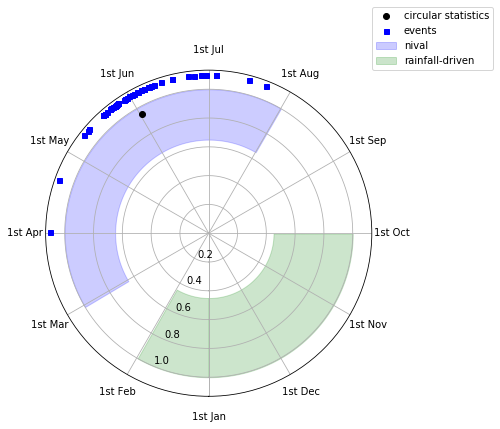

In [18]:
# Calculate streamflow centre of mass (COM)
streamflow_stats_COM = streamflow_peaks_statistics(streamflow_data_df, flag=3)

display(streamflow_stats_COM.head())

# Create polar plot
theta_rad_COM, regularity_COM = circular_stats(streamflow_stats_COM.doy.values, streamflow_stats_COM.length_year.values)
polar_plot(theta_rad_COM, regularity_COM, 0, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

Note that there are more events for the streamflow POT than for the 2 other metrics because:
- Multiple events can be identified per year.
- Years with missing values aren't discarded, but they are for the 2 other metrics calculations.

## For all basins
Now that we know how the regime classification works, let's run the regime classification for all basins where we have streamflow observations. But first for context, we plot maps of all basins with streamflow observations available in the dataset we are using.

In [22]:
# Merge all shapefiles into one Pandas GeoDataFrame

# Initialize counter
count = 0

# Loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
for r in HYDAT_regions:

    # open streamflow observations data
    streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")

    # open basin shapefiles
    basins_shp = gpd.read_file(shp_path+r+".shp")

    # extract list of basins which are both in the streamflow observations dataset and in the basins shapefiles
    basins_to_keep = set.intersection(set(streamflow_data_ds.Station_ID.data), set(basins_shp['Station'].values))
    
    # extract only basins shapefiles with streamflow data
    basins_with_data_shp = basins_shp[basins_shp['Station'].isin(list(basins_to_keep))]
    
    # read streamflow observations as Pandas DataFrame
    streamflow_data_da = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
    streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})
    streamflow_data_df = streamflow_data_da.Station_ID.to_dataframe()
    
    # add streamflow observation station lat & lon to basins shapefiles dataframe
    basins_with_data_shp['outlet_lon'] = streamflow_data_df[streamflow_data_df['Station_ID'].isin(list(basins_to_keep))].lon.values
    basins_with_data_shp['outlet_lat'] = streamflow_data_df[streamflow_data_df['Station_ID'].isin(list(basins_to_keep))].lat.values

    count += 1

    # append shapefiles
    if count == 1:
        merged_basins_shp = basins_with_data_shp
    else:
        merged_basins_shp = merged_basins_shp.append(basins_with_data_shp)

# Create basin outlets dataframe
merged_basins_pt = merged_basins_shp.copy()
merged_basins_pt = gpd.GeoDataFrame(merged_basins_pt, geometry=gpd.points_from_xy(merged_basins_pt.outlet_lon, merged_basins_pt.outlet_lat))
merged_basins_pt.crs = {"init":"epsg:4326"}

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


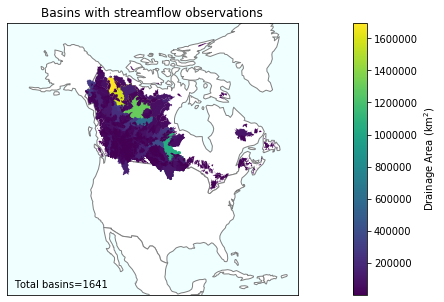

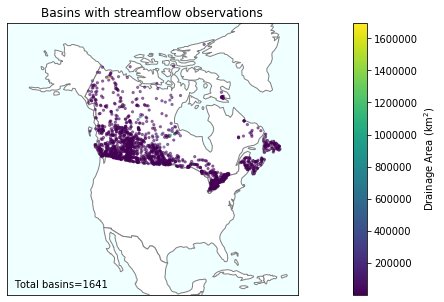

In [23]:
# Maps of all basins with streamflow observations available in the dataset 

# Plot map of basins' shapes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_na = world[world['continent']=='North America'].copy()
world_na_albers = world_na.to_crs("ESRI:102008")
ax = world_na_albers.plot(figsize=(20,5), linewidth=1, edgecolor='grey', color='white')
merged_basins_shp_albers = merged_basins_shp.to_crs("ESRI:102008")
# sorting the basins by area so that smaller basins aren't hidden under larger basins that encompass them
merged_basins_shp_albers.sort_values(by=['Shp_Area'], ascending=False).plot(ax=ax, column='Shp_Area', cmap=plt.cm.viridis, legend=True, legend_kwds={'label':'Drainage Area (km$^2$)'})  
minx, miny, maxx, maxy = np.nanmin(world_na_albers.geometry.bounds.minx),np.nanmin(world_na_albers.geometry.bounds.miny),np.nanmax(world_na_albers.geometry.bounds.maxx),np.nanmax(world_na_albers.geometry.bounds.maxy)
ax.set_xlim(minx+1500000, maxx-500000)
ax.set_ylim(miny+1000000, maxy-500000)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.title('Basins with streamflow observations')
plt.text(minx+1700000,miny+1200000,'Total basins='+str(len(merged_basins_shp.index)))
ax.set_facecolor('azure');

# Plot map of basins' outlets
ax = world_na_albers.plot(figsize=(20,5), linewidth=1, edgecolor='grey', color='white')
merged_basins_pt_albers = merged_basins_pt.to_crs("ESRI:102008")
merged_basins_pt_albers.plot(ax=ax, column='Shp_Area', cmap=plt.cm.viridis, legend=True, legend_kwds={'label':'Drainage Area (km$^2$)'}, alpha=.5, markersize=5)             
ax.set_xlim(minx+1500000, maxx-500000)
ax.set_ylim(miny+1000000, maxy-500000)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.title('Basins with streamflow observations')
plt.text(minx+1700000,miny+1200000,'Total basins='+str(len(merged_basins_shp.index)))
ax.set_facecolor('azure');

### Based on streamflow annual maxima (annual Qmax)

In [24]:
# Regime classification from streamflow annual maxima
# Note: This takes a while to run as it loops over all basins
basins_regimes_annualmax = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=1)

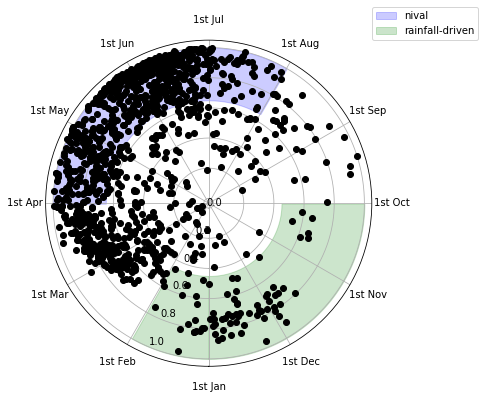

In [36]:
# Create polar plot
polar_plot(basins_regimes_annualmax.theta_rad.dropna().values, basins_regimes_annualmax.regularity.dropna().values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

In [37]:
# Identify only nival/glacial basins
nival_basins_annualmax = basins_regimes_annualmax[(basins_regimes_annualmax["doy"] >= nival_start_doy_default) & (basins_regimes_annualmax["doy"] <= nival_end_doy_default) & (basins_regimes_annualmax["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow annual maxima: There are "+str(len(nival_basins_annualmax.index))+" nival/glacial basins")

Based on streamflow annual maxima: There are 728 nival/glacial basins


/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


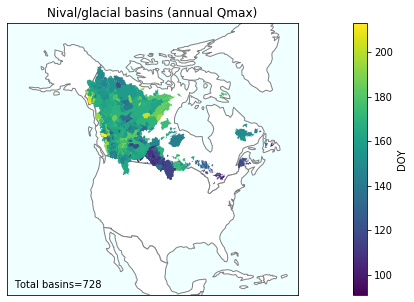

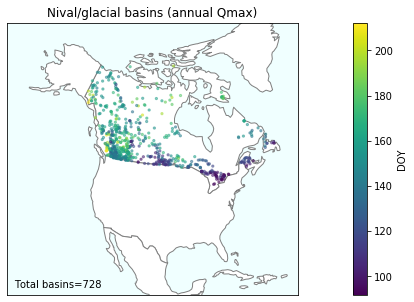

In [61]:
# Plot nival/glacial basins on map
basins_maps(nival_basins_annualmax, method='annual Qmax', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow peak over threshold (POT)

In [38]:
# Regime classification from POT
# Note: This takes a while to run as it loops over all basins
basins_regimes_POT = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=2)

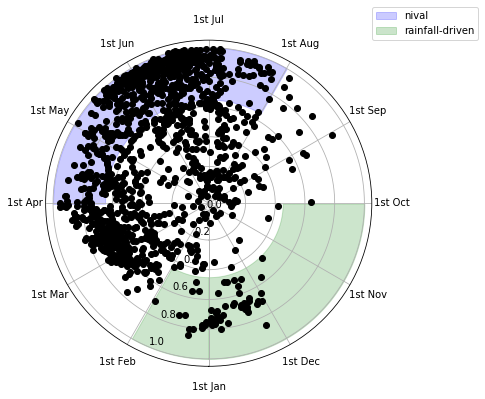

In [39]:
# Create polar plot
polar_plot(basins_regimes_POT.theta_rad.dropna().values, basins_regimes_POT.regularity.dropna().values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

In [40]:
# Identify only nival/glacial basins
nival_basins_POT = basins_regimes_POT[(basins_regimes_POT["doy"] >= nival_start_doy_default) & (basins_regimes_POT["doy"] <= nival_end_doy_default) & (basins_regimes_POT["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow POT: There are "+str(len(nival_basins_POT.index))+" nival/glacial basins")

Based on streamflow POT: There are 589 nival/glacial basins


/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


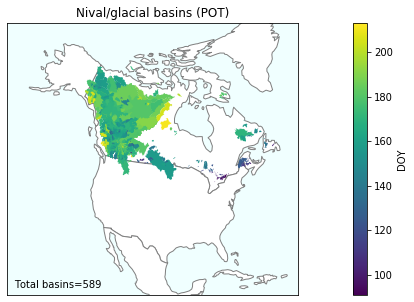

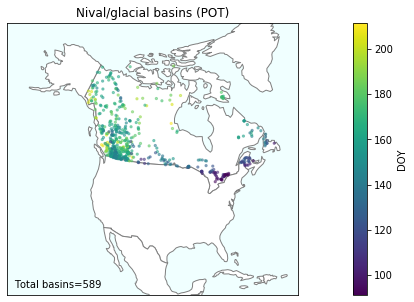

In [64]:
# Plot nival/glacial basins on map
basins_maps(nival_basins_POT, method='POT', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow centre of mass (COM)

In [41]:
# Regime classification from COM
# Note: This takes a while to run as it loops over all basins
basins_regimes_COM = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=3)

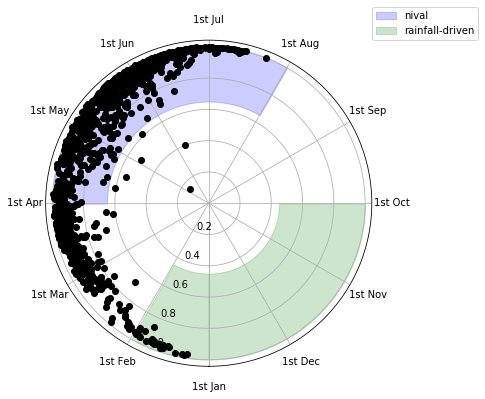

In [42]:
# Create polar plot
polar_plot(basins_regimes_COM.theta_rad.dropna().values, basins_regimes_COM.regularity.dropna().values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

In [43]:
# Identify only nival/glacial basins
nival_basins_COM = basins_regimes_COM[(basins_regimes_COM["doy"] >= nival_start_doy_default) & (basins_regimes_COM["doy"] <= nival_end_doy_default) & (basins_regimes_COM["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow COM: There are "+str(len(nival_basins_COM.index))+" nival/glacial basins")

Based on streamflow COM: There are 865 nival/glacial basins


/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


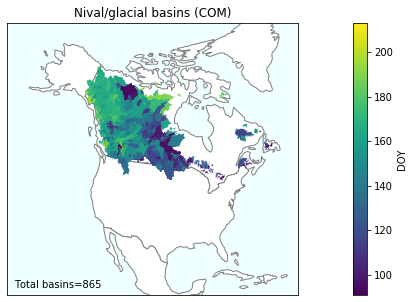

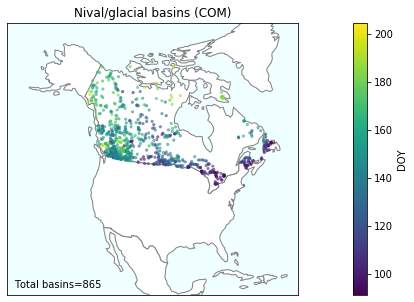

In [68]:
# Plot nival/glacial basins on map
basins_maps(nival_basins_COM, method='COM', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

# Extract overlapping basins for 3 methods
We now extract all nival/glacial basins that appear in all 3 lists, based on: annual Qmax, POT & COM. Because each method has its limitations, selecting basins that were consistently picked up by all 3 methods gives us some added confidence.

In [44]:
# Extract nival/glacial basins with SWE observations & limited regulation identified by all 3 methods
overlapping_nival_basins_list = set.intersection(set(nival_basins_annualmax.index.values), set(nival_basins_POT.index.values), set(nival_basins_COM.index.values))
overlapping_nival_basins = nival_basins_annualmax.copy().loc[overlapping_nival_basins_list]

print("Based on all 3 methods: There are "+str(len(overlapping_nival_basins.index))+" nival/glacial basins")

Based on all 3 methods: There are 534 nival/glacial basins


In [45]:
# Re-organize the dataset to save circular statistics from all 3 methods

# rename the circular statistics from streamflow annual maxima - these are the ones that were automatically added to the dataset (see cell above)
overlapping_nival_basins = overlapping_nival_basins.rename(columns={"theta_rad": "theta_rad_Qmax", "regularity": "regularity_Qmax", "doy": "doy_Qmax", })

# add the circular statistics from streamflow POT
overlapping_nival_basins['theta_rad_QPOT'] = nival_basins_POT['theta_rad'][overlapping_nival_basins.index]
overlapping_nival_basins['regularity_QPOT'] = nival_basins_POT['regularity'][overlapping_nival_basins.index]
overlapping_nival_basins['doy_QPOT'] = nival_basins_POT['doy'][overlapping_nival_basins.index]

# add the circular statistics from streamflow COM
overlapping_nival_basins['theta_rad_QCOM'] = nival_basins_COM['theta_rad'][overlapping_nival_basins.index]
overlapping_nival_basins['regularity_QCOM'] = nival_basins_COM['regularity'][overlapping_nival_basins.index]
overlapping_nival_basins['doy_QCOM'] = nival_basins_COM['doy'][overlapping_nival_basins.index]

display(overlapping_nival_basins.head())

,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea,outlet_lat,outlet_lon,theta_rad_Qmax,regularity_Qmax,doy_Qmax,theta_rad_QPOT,regularity_QPOT,doy_QPOT,theta_rad_QCOM,regularity_QCOM,doy_QCOM
08LB069,BARRIERE RIVER BELOW SPRAGUE CREEK,08LB069_1,624.120972,132.628006,"POLYGON Z ((-119.94133 51.24692 0.00000, -119....",None,51.245331,-119.937698,2.539217,0.976764,147.600136,2.672055,0.960347,155.354710,2.588151,0.988845,150.446993
08NH120,MOYIE RIVER ABOVE NEGRO CREEK,08NH120_1,239.251999,76.074097,"POLYGON Z ((-116.04768 49.46350 0.00000, -116....",None,49.422150,-115.941292,2.438735,0.942372,141.740039,2.515215,0.964461,146.199772,2.450678,0.990552,142.457413
07ED003,NATION RIVER NEAR THE MOUTH,07ED003_1,6789.600098,555.091980,"POLYGON Z ((-123.70898 55.46305 0.00000, -123....",NaN,55.427219,-123.633362,2.549085,0.986200,148.181720,2.630341,0.970917,152.925712,2.576206,0.992537,149.756632
08NL045,KEREMEOS CREEK BELOW WILLIS INTAKE,08NL045_1,180.643005,67.321503,"POLYGON Z ((-119.84925 49.25339 0.00000, -119....",None,49.258900,-119.825790,2.586091,0.978207,150.337997,2.763578,0.901193,160.653077,2.600414,0.985921,151.171388
08EB006,COMPASS CREEK NEAR KISPIOX,08EB006_1,19.058701,21.514200,"POLYGON Z ((-127.87502 55.45989 0.00000, -127....",None,55.458328,-127.852501,2.530488,1.000000,147.000000,2.650603,0.987974,154.080409,2.513274,1.000000,146.000000


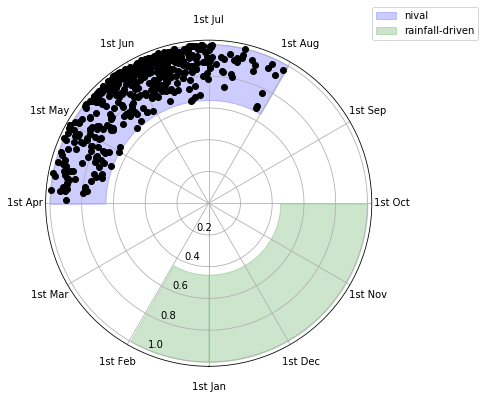

In [46]:
# Create polar plot
# Note: We use the annual Qmax circular statistics for plotting - any other could be used by replacing the strings provided for theta_rad & regularity below
polar_plot(overlapping_nival_basins['theta_rad_Qmax'].values, overlapping_nival_basins['regularity_Qmax'].values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


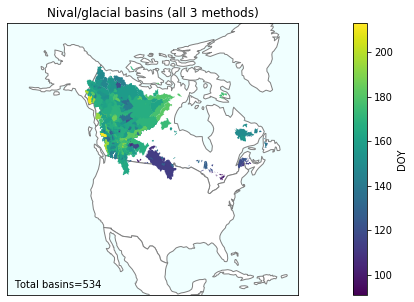

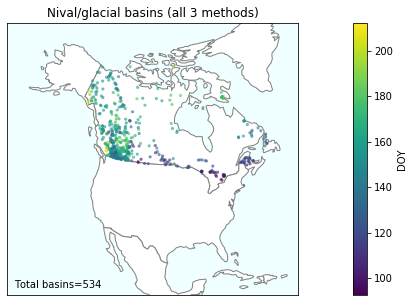

In [76]:
# Plot nival/glacial basins on map
basins_maps(overlapping_nival_basins, method='all 3 methods', title_end='', colours_column='doy_Qmax', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

# Sub-selection of basins with SWE stations & limited regulation

## Sub-select nival basins with SWE stations
Now that we have identified all basins with a nival regime, we need to find out which of these have at least 1 SWE station with at least X years (pre-defined at the top of the Notebook) of overlapping SWE and streamflow data.

In [47]:
# Identify basins with at least 1 SWE station
# Note: this takes a while to run as it loops over all basins

# read the SWE stations observations file - this automatically closes the dataset after use, necessary for memory reasons
with xr.open_dataset(SWE_obs_path) as ds:

    # re-organize the dataset as needed - we need to have time, station_id, lon, lat and station_name as coordinates and snw as variable
    SWE_stations_ds = ds.assign_coords({'lon':ds.lon,'lat':ds.lat,'station_name':ds.station_name}).snw.to_dataset()
    data = {'station_id': SWE_stations_ds.station_id.data, 'lon': SWE_stations_ds.lon.data, 'lat': SWE_stations_ds.lat.data} 
    df = pd.DataFrame(data)
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    SWE_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    
# manually trigger loading of this dataset into memory and return it
SWE_stations_ds.load()
    
# set empty dictionary to store basins' info for overlapping SWE & streamflow data (e.g., number of overlapping years)
basins_with_swe_info = {}

# loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
for r in ['01','02','03','04','05','06','07','08','09','10','11']:

    # read streamflow observations as xarray DataSet
    streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
    streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
    streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})
    
    # open basin shapefiles
    basins_shp = gpd.read_file(shp_path+r+".shp")  
    
    # loop over stations with streamflow data within the region
    for s in streamflow_data_ds.Station_ID.values:

        # check that the station has a corresponding basin shapefile 
        if s in basins_shp.Station.values:

            # read streamflow observations for basin as xarray DataArray
            streamflow_data_da = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow

            # extract SWE stations in basin only
            SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, basins_shp, s, buffer_km=0)[0]

            # if there is/are (a) station(s) within the basin we can proceed
            if SWE_stations_in_basin.empty == False:

                # transform the xarray DataArray to a Pandas DataFrame for data manipulations
                SWE_stations_df = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values).to_dataframe()
                SWE_stations_df = SWE_stations_df.drop(columns=['lon','lat','station_name']).unstack()['snw'].T

                # calculate the annual max (averaged over all SWE stations), as a proxy for data availability for any given year
                SWE_annualmax = SWE_stations_df.groupby(SWE_stations_df.index.year).max()
                SWE_annualmax = SWE_annualmax.mean(axis=1)

                # calculate the streamflow annual maxima
                streamflow_data_df = streamflow_data_da.to_dataframe()
                streamflow_data_df.reset_index(inplace=True)
                streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)
                streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
                streamflow_data_df = streamflow_data_df.set_index('doy')
                streamflow_annualmax = streamflow_data_df.groupby("year").Flow.max().dropna(axis=0)

                # combine streamflow & SWE timeseries and remove any years with missing data
                SWE_Q_timeseries = pd.DataFrame(data=SWE_annualmax.copy(), index=SWE_annualmax.index.values, columns=["SWE"])
                SWE_Q_timeseries['Flow'] = streamflow_annualmax
                SWE_Q_timeseries = SWE_Q_timeseries.dropna(axis=0, how='any')
                
                # if there is more than 1 year of overlapping data, save basin overlapping data information
                if len(SWE_Q_timeseries.index) > 0:
                    basins_with_swe_info[s] = [SWE_Q_timeseries.index.values[0], SWE_Q_timeseries.index.values[-1], len(SWE_Q_timeseries.index)]

                else:
                    continue
            
            else:
                continue
                
# Save basins with at least 1 SWE station to a Pandas DataFrame
basins_with_swe = pd.DataFrame.from_dict(basins_with_swe_info, orient='index', columns=['start_year', 'end_year', 'total_years'])

In [48]:
# Identify basins with at least 1 SWE station that meet the data overlap requirements
# i.e., at least X years of overlapping data (see pre-defined variables at the top of the Notebook)
selected_basins_with_swe = basins_with_swe[basins_with_swe.total_years >= min_years_overlap_default]

display(selected_basins_with_swe)

,start_year,end_year,total_years
01AD002,1955,2014,60
01AD003,1958,2015,58
01AF002,1955,2015,61
01AF007,1982,2014,33
01AH002,1956,2013,57
...,...,...,...
10LC014,1972,2015,44
10MA001,1976,2014,33
10MC002,1976,2015,39
11AB082,1962,2015,48


In [49]:
# Extract only nival/glacial basins with SWE observations
overlapping_nival_basins_withSWE = overlapping_nival_basins.copy().reindex(index=selected_basins_with_swe.index.values).dropna(axis=0, how='all')

print("There are "+str(len(overlapping_nival_basins_withSWE.index))+" nival/glacial basins with SWE observations")

There are 194 nival/glacial basins with SWE observations


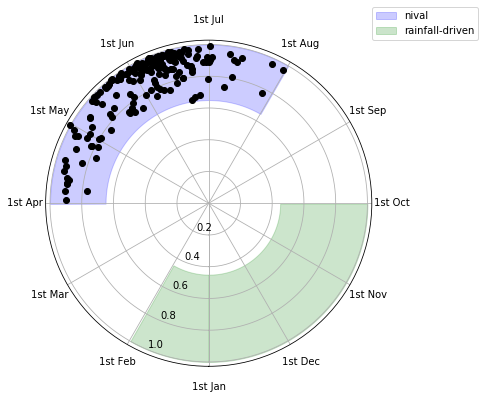

In [50]:
# Create polar plot
# Note: We use the annual Qmax circular statistics for plotting
polar_plot(overlapping_nival_basins_withSWE['theta_rad_Qmax'].values, overlapping_nival_basins_withSWE['regularity_Qmax'].values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


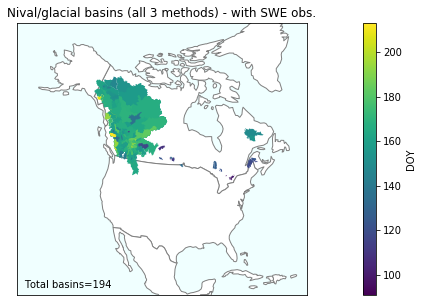

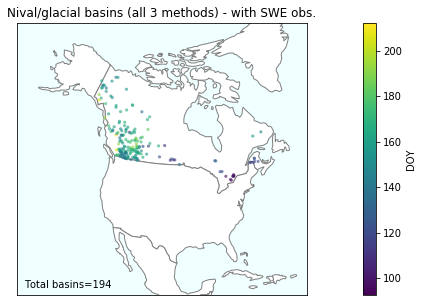

In [89]:
# Plot nival/glacial basins on map
basins_maps(overlapping_nival_basins_withSWE, method='all 3 methods', title_end=' - with SWE obs.', colours_column='doy_Qmax', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

## Sub-select nival basins with limited regulation
We now identify basins with limited human influence, taken from the RHBN dataset (defined in the paths at the top of the Notebook).

In [51]:
# Read metadata for RHBN stations with limited human influence across Canada
RHBN_stations = pd.read_excel(RHBN_stations_path, header=2, skiprows=[3])
RHBN_stations = RHBN_stations[RHBN_stations["Evaluation_Year"] == 2020]
display(RHBN_stations)

,STATION_NUMBER,Evaluation_Year,RHBN-N,DATA_TYPE,Yield,Ecoregion,Data.Quality,Years.C,Years.S,Watershed.Quality,Percent_Human.Impact,Percent.Urban,Road.Density,Pop.Density,Flow.Structures,Reservoir.Pct,GRanD
0,01AD002,2020,1,Q,600.0,Northern Forests,C,88.0,NaN,2.0,0.340,0.032,0.14,71.0,72.0,0.170,Lock Dam
1,01AD003,2020,1,Q,590.0,Northern Forests,C,65.0,NaN,2.0,0.027,0.000,0.00,71.0,18.0,0.680,NaN
2,01AJ004,2020,1,Q,650.0,Eastern Temperate Forests,C,49.0,NaN,4.0,26.000,0.000,0.00,71.0,8.0,0.110,NaN
3,01AJ010,2020,1,Q,710.0,Eastern Temperate Forests,C,43.0,1.0,1.0,0.140,0.000,0.31,23.0,1.0,0.001,NaN
4,01AK001,2020,1,Q,680.0,Eastern Temperate Forests,C,95.0,NaN,1.0,0.000,0.000,0.14,2.0,0.0,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,11AA032,2020,0,Q,110.0,Great Plains,S,NaN,81.0,3.0,68.000,0.000,0.01,71.0,0.0,0.000,NaN
1278,11AC025,2020,0,Q,14.0,Great Plains,S,NaN,69.0,1.0,5.000,0.000,0.33,1.0,52.0,0.048,NaN
1279,11AE008,2020,0,Q,17.0,Great Plains,S,NaN,84.0,3.0,34.000,0.000,0.49,NaN,10.0,0.000,NaN
1280,11AE009,2020,0,Q,17.0,Great Plains,C,37.0,34.0,3.0,12.000,0.000,0.00,71.0,10.0,0.008,NaN


In [53]:
# Extract only nival/glacial basins with SWE obs. & limited regulation
nival_basins_withSWE_RHBN_list = set.intersection(set(RHBN_stations['STATION_NUMBER'].values), set(overlapping_nival_basins_withSWE.index.values))
nival_basins_withSWE_nat = overlapping_nival_basins_withSWE.copy().loc[nival_basins_withSWE_RHBN_list]

print("There are "+str(len(nival_basins_withSWE_nat.index))+" nival/glacial basins with SWE obs. & limited regulation")

There are 110 nival/glacial basins with SWE obs. & limited regulation


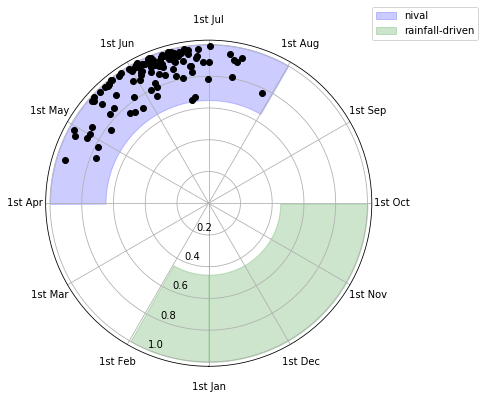

In [54]:
# Create polar plot
# Note: We use the annual Qmax circular statistics for plotting
polar_plot(nival_basins_withSWE_nat['theta_rad_Qmax'].values, nival_basins_withSWE_nat['regularity_Qmax'].values, 1, nival_start_doy_default, nival_end_doy_default, nival_regularity_threshold_default, raindriven_start_doy_default, raindriven_end_doy_default, raindriven_regularity_threshold_default)

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


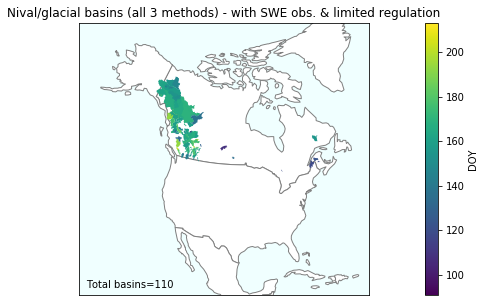

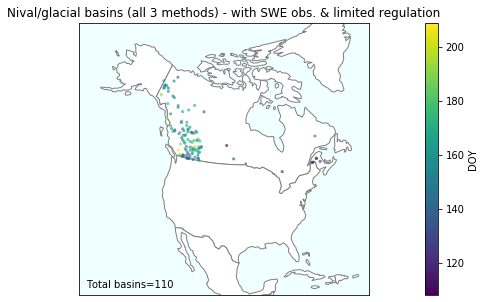

In [96]:
# Plot nival/glacial basins on map
basins_maps(nival_basins_withSWE_nat, method='all 3 methods', title_end=' - with SWE obs. & limited regulation', colours_column='doy_Qmax', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

# Identify glacial basins
We need to identify basins that are dominantly glacial within this dataset, as this involves a different streamflow generation process. We identify these basins as having their peak DOY at or after a pre-defined date (set in user-defined variables at the top of the Notebook).

In [97]:
# Extract basins with a DOY >= X (pre-defined above; for at least one of these 3 methods)
glacial_basins = nival_basins_withSWE_nat[(nival_basins_withSWE_nat.doy_Qmax>=glacial_min_doy_default) | (nival_basins_withSWE_nat.doy_QPOT>=glacial_min_doy_default) | (nival_basins_withSWE_nat.doy_QCOM>=glacial_min_doy_default)]

display(glacial_basins)

,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea,outlet_lat,outlet_lon,theta_rad_Qmax,regularity_Qmax,doy_Qmax,theta_rad_QPOT,regularity_QPOT,doy_QPOT,theta_rad_QCOM,regularity_QCOM,doy_QCOM
07AG004,MCLEOD RIVER NEAR WHITECOURT,07AG004_1,9108.998403,587.463971,"POLYGON Z ((-115.83840 54.01159 0.00000, -115....",NaN,54.012451,-115.839729,3.339556,0.908818,194.000000,3.142507,0.924181,182.649830,2.935022,0.890028,170.500000
08NB014,GOLD RIVER ABOVE PALMER CREEK,08NB014_1,428.869995,109.872002,"POLYGON Z ((-117.71863 51.67794 0.00000, -117....",None,51.677990,-117.718498,3.142105,0.892842,182.657491,3.178754,0.935975,184.792374,3.184998,0.994801,185.148570
09AA013,TUTSHI RIVER AT OUTLET OF TUTSHI LAKE,09AA013_1,989.395996,224.251999,"POLYGON Z ((-135.11953 59.62313 0.00000, -135....",NaN,59.947781,-134.332504,2.980163,0.982776,173.247441,3.176691,0.937667,184.675948,3.030829,0.993328,176.192872
08NA002,COLUMBIA RIVER AT NICHOLSON,08NA002_1,6663.680176,525.593994,"POLYGON Z ((-116.91302 51.24232 0.00000, -116....",None,51.243561,-116.912933,3.071921,0.973063,178.569195,3.217089,0.931237,187.013515,3.070411,0.994102,178.481997
08MG013,HARRISON RIVER NEAR HARRISON HOT SPRINGS,08MG013_1,7885.839844,856.663025,"POLYGON Z ((-121.83028 49.29231 0.00000, -121....",None,49.300419,-121.829643,3.139308,0.783842,182.462029,3.151294,0.828439,183.196619,2.668657,0.984205,155.137249
07OB001,HAY RIVER NEAR HAY RIVER,07OB001_1,51382.997725,1909.604358,"POLYGON Z ((-115.85316 60.74405 0.00000, -115....",NaN,60.743000,-115.859642,2.356733,0.847923,136.988633,3.173721,0.690953,184.480727,2.632938,0.947539,153.056362
09CD001,YUKON RIVER ABOVE WHITE RIVER,09CD001_1,149347.229154,3246.830544,"POLYGON Z ((-139.85081 63.13083 0.00000, -139....",NaN,63.082500,-139.496933,2.874205,0.943091,167.076667,3.209998,0.861829,186.619356,2.886159,0.992569,167.776890
05DA009,NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT,05DA009_1,1923.213400,288.653423,"POLYGON Z ((-117.18359 52.26746 0.00000, -117....",NaN,52.001190,-116.470932,3.369934,0.936370,195.881206,3.430917,0.935700,199.443662,3.345099,0.996176,194.444451
05DB006,CLEARWATER RIVER NEAR DOVERCOURT,05DB006_1,2252.758123,376.296699,"POLYGON Z ((-114.84873 52.25811 0.00000, -114....",NaN,52.252102,-114.855820,3.103559,0.890499,180.416608,3.192115,0.885603,185.530979,2.928597,0.983566,170.248201
05BA001,BOW RIVER AT LAKE LOUISE,05BA001_1,422.433422,124.571480,"POLYGON Z ((-116.45854 51.72693 0.00000, -116....",NaN,51.428600,-116.188942,3.002836,0.946668,174.544287,3.151727,0.945890,183.232357,3.205618,0.993755,186.329078


In [100]:
# Add regime column to the dataset with a 'glacial' identifier for those basins
nival_basins_withSWE_nat['regime'] = 'nival'
nival_basins_withSWE_nat['regime'].loc[glacial_basins.index] = ['glacial']*len(glacial_basins.index)

display(nival_basins_withSWE_nat.head())

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea,outlet_lat,outlet_lon,theta_rad_Qmax,regularity_Qmax,doy_Qmax,theta_rad_QPOT,regularity_QPOT,doy_QPOT,theta_rad_QCOM,regularity_QCOM,doy_QCOM,regime
07AG004,MCLEOD RIVER NEAR WHITECOURT,07AG004_1,9108.998403,587.463971,"POLYGON Z ((-115.83840 54.01159 0.00000, -115....",NaN,54.012451,-115.839729,3.339556,0.908818,194.000000,3.142507,0.924181,182.649830,2.935022,0.890028,170.500000,glacial
01AD002,SAINT JOHN RIVER AT FORT KENT,01AD002_1,14703.921076,1195.744737,"POLYGON Z ((-69.27594 47.81781 0.00000, -69.27...",NaN,47.258060,-68.595833,2.033428,0.943063,118.193348,2.163263,0.796013,125.759695,2.064564,0.987343,120.015886,nival
08NB014,GOLD RIVER ABOVE PALMER CREEK,08NB014_1,428.869995,109.872002,"POLYGON Z ((-117.71863 51.67794 0.00000, -117....",None,51.677990,-117.718498,3.142105,0.892842,182.657491,3.178754,0.935975,184.792374,3.184998,0.994801,185.148570,glacial
09AA013,TUTSHI RIVER AT OUTLET OF TUTSHI LAKE,09AA013_1,989.395996,224.251999,"POLYGON Z ((-135.11953 59.62313 0.00000, -135....",NaN,59.947781,-134.332504,2.980163,0.982776,173.247441,3.176691,0.937667,184.675948,3.030829,0.993328,176.192872,glacial
10BE001,LIARD RIVER AT LOWER CROSSING,10BE001_1,104355.000000,2610.129883,"POLYGON Z ((-126.11187 59.39868 0.00000, -126....",NaN,59.412498,-126.097221,2.845027,0.973026,165.398897,2.929531,0.959961,170.309437,2.884555,0.992603,167.696677,nival


/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


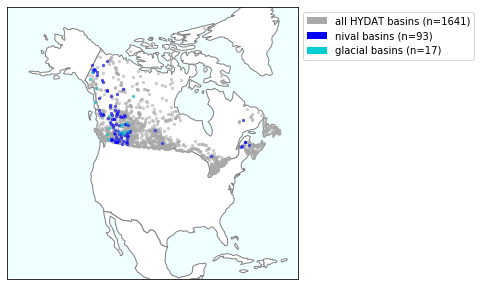

In [52]:
# # Plot final map of all basins, identifying nival and glacial basins
# fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(20,10))

# Calculate the total amount of basins per category
ntot = len(merged_basins_shp.index)
nniv = len(nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='nival'])
nglac = len(nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='glacial'])

# Plot map of basins' outlets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_na = world[world['continent']=='North America'].copy()
world_na_albers = world_na.to_crs("ESRI:102008")
ax = world_na_albers.plot(figsize=(20,5), linewidth=1, edgecolor='grey', color='white')

merged_basins_pt = merged_basins_shp.copy()
merged_basins_pt = gpd.GeoDataFrame(merged_basins_pt, geometry=gpd.points_from_xy(merged_basins_pt.outlet_lon, merged_basins_pt.outlet_lat))
merged_basins_pt.crs = {"init":"epsg:4326"}
merged_basins_pt_albers = merged_basins_pt.to_crs("ESRI:102008")
merged_basins_pt_albers.plot(ax=ax, c='darkgrey', legend=True, legend_kwds={'label':'all HYDAT basins ('+str(ntot)+')'}, alpha=.5, markersize=5)            

nival_basins_withSWE_nat_pt = nival_basins_withSWE_nat.copy()
nival_basins_withSWE_nat_pt = gpd.GeoDataFrame(nival_basins_withSWE_nat_pt, geometry=gpd.points_from_xy(nival_basins_withSWE_nat_pt.outlet_lon, nival_basins_withSWE_nat_pt.outlet_lat))
nival_basins_withSWE_nat_pt.crs = {"init":"epsg:4326"}
nival_basins_withSWE_nat_pt_albers = nival_basins_withSWE_nat_pt.to_crs("ESRI:102008")
nival_basins_withSWE_nat_pt_albers[nival_basins_withSWE_nat_pt_albers.regime=='nival'].plot(ax=ax, c='blue', legend=True, legend_kwds={'label':'nival basins ('+str(nniv)+')'}, alpha=.5, markersize=5)            
nival_basins_withSWE_nat_pt_albers[nival_basins_withSWE_nat_pt_albers.regime=='glacial'].plot(ax=ax, c='darkturquoise', legend=True, legend_kwds={'label':'glacial basins ('+str(nglac)+')'}, alpha=.5, markersize=5)            

pmarks = []
pmarks.append(Patch(facecolor='darkgrey', label='all HYDAT basins (n='+str(ntot)+')'))
pmarks.append(Patch(facecolor='blue', label='nival basins (n='+str(nniv)+')'))
pmarks.append(Patch(facecolor='darkturquoise', label='glacial basins (n='+str(nglac)+')'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles,*pmarks], bbox_to_anchor=(1,1))
minx, miny, maxx, maxy = np.nanmin(world_na_albers.geometry.bounds.minx),np.nanmin(world_na_albers.geometry.bounds.miny),np.nanmax(world_na_albers.geometry.bounds.maxx),np.nanmax(world_na_albers.geometry.bounds.maxy)
ax.set_xlim(minx+1500000, maxx-500000)
ax.set_ylim(miny+1000000, maxy-500000)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.savefig(plots_output_path+'nival_glacial_basins_map.png', dpi=300, bbox_inches='tight');

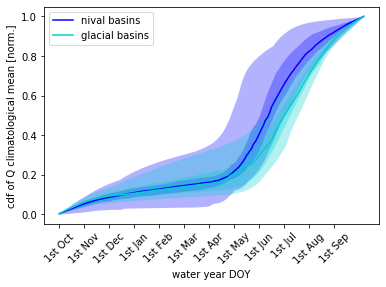

In [69]:
# Plot cdf hydrographs for nival vs. glacial basins
fig  = cumulative_hydrographs(nival_basins_withSWE_nat, streamflow_obs_path, month_start_water_year=month_start_water_year_default, day_start_water_year=day_start_water_year_default)
fig.savefig(plots_output_path+'nival_glacial_basins_Qcdf.png', dpi=300, bbox_inches='tight')

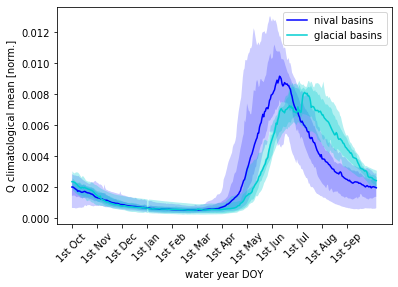

In [27]:
# Plot cdf hydrographs for nival vs. glacial basins
fig = hydrographs(nival_basins_withSWE_nat, streamflow_obs_path, month_start_water_year=month_start_water_year_default, day_start_water_year=day_start_water_year_default)
fig.savefig(plots_output_path+'nival_glacial_basins_hydrographs.png', dpi=300, bbox_inches='tight')

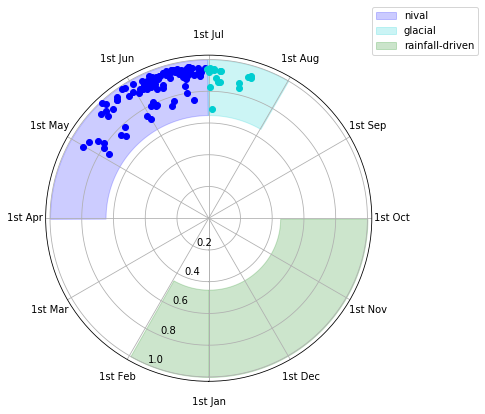

In [12]:
# Create polar plot
# Note: We use the POT circular statistics for plotting

# Initialize the figure
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(polar=True)
lines, labels = plt.thetagrids(np.arange(0,361,30),['1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'])
ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.tick_params(pad=10)

# Plot circular statistics for multiple basins - i.e., individual events are not shown
plt.plot(nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='nival']['theta_rad_QPOT'], nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='nival']['regularity_QPOT'], 'bo')
plt.plot(nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='glacial']['theta_rad_QPOT'], nival_basins_withSWE_nat[nival_basins_withSWE_nat.regime=='glacial']['regularity_QPOT'], 'o', c='darkturquoise')

# Add information on polar plot about rainfall-driven & nival regimes
nival_start = nival_start_doy_default * ((2*math.pi)/365)
nival_end = glacial_min_doy_default * ((2*math.pi)/365)
plt.fill_between(np.linspace(nival_start, nival_end, 100), nival_regularity_threshold_default, 1, color='b', alpha=.2, label='nival')
glacial_start = glacial_min_doy_default * ((2*math.pi)/365)
glacial_end = nival_end_doy_default * ((2*math.pi)/365)
plt.fill_between(np.linspace(glacial_start, glacial_end, 100), nival_regularity_threshold_default, 1, color='darkturquoise', alpha=.2, label='glacial')

raindriven_start_1 = raindriven_start_doy_default * ((2*math.pi)/365)
raindriven_end_1 = 365 * ((2*math.pi)/365)
raindriven_start_2 = 0 * ((2*math.pi)/365)
raindriven_end_2 = raindriven_end_doy_default * ((2*math.pi)/365)
plt.fill_between(np.linspace(raindriven_start_1, raindriven_end_1, 100), raindriven_regularity_threshold_default, 1, color='g', alpha=.2, label='rainfall-driven')
plt.fill_between(np.linspace(raindriven_start_2, raindriven_end_2, 100), raindriven_regularity_threshold_default, 1, color='g', alpha=.2)

plt.legend(loc=(1,1));

fig.savefig(plots_output_path+'nival_glacial_basins_polarplot_QPOT.png', dpi=300, bbox_inches='tight')

In [11]:
%store -r nival_basins_withSWE_RHBN

# Store data
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [71]:
%store nival_basins_withSWE_nat

Stored 'nival_basins_withSWE_RHBN' (GeoDataFrame)
